# **FLIGHT DELAY ANALYSIS**

**Dataset**

We have taken data from the harvard dataverse which had the flight data from 1998 to 2008. 



**INSTALLING ALL THE LIBRARIES**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import csv
from textwrap import wrap
from datetime import datetime

!pip3 install pyspark
!pip3 install pymongo

!apt install mongodb
!service mongodb start

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=eb9568a693068553092c6664a885ef5b1acb91f1cc4bcfc0c5e84798d4456e32
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 27.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpcap0.8 libyaml-cpp0.6 mongo-tools mongodb-clients mongodb-server
  mo

In [7]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
%matplotlib inline

**Initializing Spark Session**

In [8]:

conf = SparkConf().setAppName('appName').setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [9]:
sqlC = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the Data**

In [13]:
df1 = sc.textFile(r'drive/My Drive/603project/2008.csv')
df2 = sc.textFile(r'drive/My Drive/603project/2007.csv')
df3 = sc.textFile(r'drive/My Drive/603project/2006.csv')
df4 = sc.textFile(r'drive/My Drive/603project/2005.csv')
df5 = sc.textFile(r'drive/My Drive/603project/2004.csv')
df6 = sc.textFile(r'drive/My Drive/603project/2003.csv')

In [14]:
df1.count()

2389218

In [15]:
type(df1)

pyspark.rdd.RDD

In [16]:
import functools

def unionAll(dfs):
    return functools.reduce(lambda df1, df2: df1.union(df2), dfs)
 
 
# spark = SparkSession.builder.getOrCreate()
 
textFile = unionAll([df1,df2,df3,df4,df5,df6])

In [17]:
textFile.count()

31254225

In [18]:
#remove the header of file
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()

textRDD = textFileRDD.filter(lambda r: r != header)

In [19]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[4])), \
          CRSDepTime=int(r[5]),\
          ArrTime=int(float(r[6])),\
          CRSArrTime=int(r[7]), \
          UniqueCarrier=r[8],\
          Cancelled=int(r[21]),\
          DepDelay=int(float(r[15])),\
          ArrDelay=int(float(r[14])),\
          Origin=r[16],\
          Dest=r[17], \
          Distance=int(float(r[18])),\
          CarrierDelay=int(float(r[24])),\
          WeatherDelay=int(float(r[25])),\
          NASDelay= int(float(r[26])),\
          SecurityDelay=int(float(r[27])),\
          LateAircraftDelay=int(float(r[28])))  
    except:
        x=None  
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
airline_df = sqlC.createDataFrame(rowRDD)

In [20]:
airline_df.show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+--------+--------+------+----+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|Cancelled|DepDelay|ArrDelay|Origin|Dest|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+--------+--------+------+----+--------+------------+------------+--------+-------------+-----------------+
|2008|    1|         3|        4|   1343|      1325|   1451|      1435|           WN|        0|      18|      16|   HOU| LIT|     393|          16|           0|       0|            0|                0|
|2008|    1|         3|        4|   1423|      1400|   1726|      1710|           WN|        0|      23|      16|   HOU| MCO|     848|          16|           0|       0|            0|         

In [21]:
airline_df.printSchema()

root
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- DepTime: long (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- ArrTime: long (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- Cancelled: long (nullable = true)
 |-- DepDelay: long (nullable = true)
 |-- ArrDelay: long (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: long (nullable = true)
 |-- CarrierDelay: long (nullable = true)
 |-- WeatherDelay: long (nullable = true)
 |-- NASDelay: long (nullable = true)
 |-- SecurityDelay: long (nullable = true)
 |-- LateAircraftDelay: long (nullable = true)



**Data Cleaning**

In [22]:
print("Count of Rows",airline_df.count())
print("Number of columns:", len(airline_df.columns))

Count of Rows 28844240
Number of columns: 20


In [23]:
airline_df=airline_df.drop_duplicates()

In [24]:
# Drop rows with null values from the DataFrame
airline_df = airline_df.dropna()

**EDA TECHNIQUES**

In [25]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

In [ ]:
# from pyspark.sql.functions import when

# df_all_years = df_all_years.withColumn("Distance", when(df_all_years["Distance"] > 10000, 10000).otherwise(df_all_years["Distance"]))

In [26]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
f = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))

In [27]:
airline_df.registerTempTable("airlineDF")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:330: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
uri = "mongodb://localhost:27017/"
database = "mydb"
collection = "flight_data"

# Define the schema for the collection
schema = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Month", IntegerType(), True),
    StructField("DayofMonth", IntegerType(), True),
    StructField("DayOfWeek", IntegerType(), True),
    StructField("UniqueCarrier", StringType(), True),
    StructField("FlightNum", StringType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("ArrDelay", IntegerType(), True),
    StructField("DepDelay", IntegerType(), True)
])

# Write the dataframe to MongoDB
airline_df.write.format("mongo").mode("append").option("uri", uri+database+"."+collection).option("spark.mongodb.output.uri", uri+database+"."+collection).option("replaceDocument", "false").schema(schema).save()


**Airport with highest Departures**


In [28]:
from pyspark.sql.functions import count, desc
airport_with_most_departure_flights = airline_df.groupBy("ORIGIN").agg(count("*").alias("departure_count")) \
                                         .orderBy(desc("departure_count")).first()["ORIGIN"]

In [19]:
airport_with_most_departure_flights

'ATL'

**Airport with highest Arrivals**

In [29]:
airport_with_most_arriving_flights = airline_df.groupBy("DEST").agg(count("*").alias("arrival_count")) \
                                        .orderBy(desc("arrival_count")).first()["DEST"]
airport_with_most_arriving_flights

'ATL'

**Busiest Airport**

In [30]:
busiest_airport = airline_df.select("ORIGIN").union(airline_df.select("DEST")) \
                    .groupBy("ORIGIN").agg(count("*").alias("total_count")) \
                    .orderBy(desc("total_count")).first()["ORIGIN"]
busiest_airport

'ATL'

**Top 10 Airports with highest Departures**

In [31]:
from pyspark.sql.functions import avg, desc
airline_df = airline_df.withColumn("DepDelayMinutes", (airline_df["DepDelay"] > 0).cast("int") * airline_df["DepDelay"])

delayed_departures = airline_df.filter("DepDelayMinutes > 0") \
                       .groupBy("ORIGIN").agg(avg("DepDelayMinutes").alias("avg_delay")) \
                       .orderBy(desc("avg_delay")).limit(10)
delayed_departures.show()             

+------+------------------+
|ORIGIN|         avg_delay|
+------+------------------+
|   FMN|             240.0|
|   OGD|             172.4|
|   CMX|116.07246376811594|
|   CYS|             105.0|
|   PUB|             104.0|
|   ALO| 83.44927536231884|
|   ACK| 69.80224719101123|
|   SPI| 69.76310122038765|
|   INL| 69.74358974358974|
|   CWA|62.279359430604984|
+------+------------------+



**Top 10 Airports with Highest Arrivals**

In [32]:
airline_df = airline_df.withColumn("ArrDelayMinutes", (airline_df["ArrDelay"] > 0).cast("int") * airline_df["ArrDelay"])

delayed_arrivals = airline_df.filter("ArrDelayMinutes > 0") \
                     .groupBy("DEST").agg(avg("ArrDelayMinutes").alias("avg_delay")) \
                     .orderBy(desc("avg_delay")).limit(10)
delayed_arrivals.show()

+----+------------------+
|DEST|         avg_delay|
+----+------------------+
| MQT|  62.6765725606736|
| SPI| 51.06264916467781|
| CMX|50.864285714285714|
| ACK|50.672380952380955|
| GCC| 49.56521739130435|
| HHH| 49.17631578947368|
| EWN| 48.87164179104477|
| EWR|47.708357717463485|
| ILG| 45.93417721518988|
| CWA| 45.48564447159438|
+----+------------------+



**Flight Count Year-Wise**

In [52]:
year_df = airline_df.groupBy('year').count()
year_df.show()

+----+-------+
|year|  count|
+----+-------+
|2007|7275259|
|2006|7003790|
|2004|6987709|
|2005|6992816|
|2008| 584581|
+----+-------+



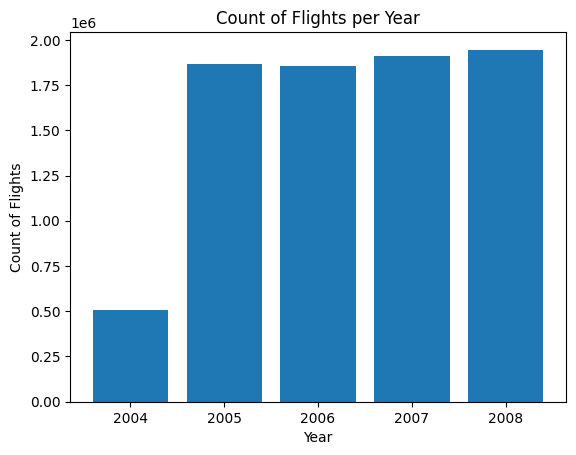

In [25]:
import matplotlib.pyplot as plt

# Extract the year and count columns from the flight_counts DataFrame
years = year_df.select("Year").rdd.flatMap(lambda x: x).collect()
counts = year_df.select("count").rdd.flatMap(lambda x: x).collect()

# Plot the graph
plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("Count of Flights")
plt.title("Count of Flights per Year")
plt.show()

**Analysing most preferred carrier from 2004 to 2008**

In [ ]:
from pyspark.sql.functions import desc
year_c_df = airline_df.groupBy('UniqueCarrier').count()
year_c_df = year_c_df.orderBy(desc("count"))
year_c_df.show()

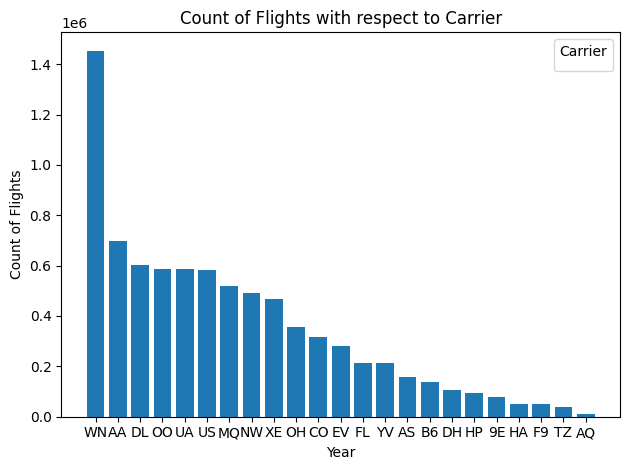

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the grouped_df DataFrame to a Pandas DataFrame for plotting
grouped_df_pd = year_c_df.toPandas()

# Pivot the DataFrame to have carriers as columns and years as rows
#pivot_df = grouped_df_pd.pivot(index='UniqueCarrier', columns='count')

# Plot the graph
plt.bar(grouped_df_pd['UniqueCarrier'],grouped_df_pd['count'])
#pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel("Year")
plt.ylabel("Count of Flights")
plt.title("Count of Flights with respect to Carrier")
plt.legend(title='Carrier', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

**Top 15 busiest airports year-wise**

In [46]:
airport_df = airline_df.groupBy('year','origin').count()
#airport_df.show()
from pyspark.sql.functions import desc, row_number
from pyspark.sql.window import Window

window_spec = Window.partitionBy("year").orderBy(desc("count"))

# Step 5: Rank origins within each year based on count
ranked_flight_counts = airport_df.withColumn("rank", row_number().over(window_spec))

# Step 6: Filter top 15 origins for each year
top_origins_yearly = ranked_flight_counts.filter("rank <= 15")

# Step 7: Show the top 15 origins with highest flight counts year-wise
top_origins_yearly.show()

+----+------+------+----+
|year|origin| count|rank|
+----+------+------+----+
|2004|   ATL|409465|   1|
|2004|   ORD|363745|   2|
|2004|   DFW|338710|   3|
|2004|   LAX|229726|   4|
|2004|   CVG|202036|   5|
|2004|   IAH|199861|   6|
|2004|   PHX|168267|   7|
|2004|   LAS|156403|   8|
|2004|   EWR|153972|   9|
|2004|   DEN|153571|  10|
|2004|   MSP|144716|  11|
|2004|   DTW|144175|  12|
|2004|   SLC|136904|  13|
|2004|   IAD|129670|  14|
|2004|   BOS|128738|  15|
|2005|   ATL|419051|   1|
|2005|   ORD|328577|   2|
|2005|   DFW|302956|   3|
|2005|   LAX|228118|   4|
|2005|   IAH|208161|   5|
+----+------+------+----+
only showing top 20 rows



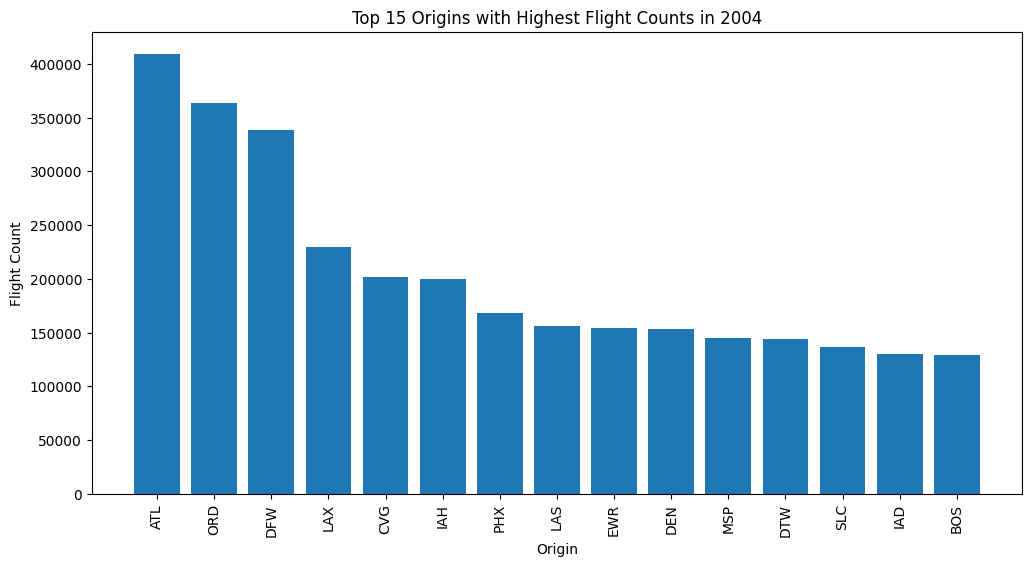

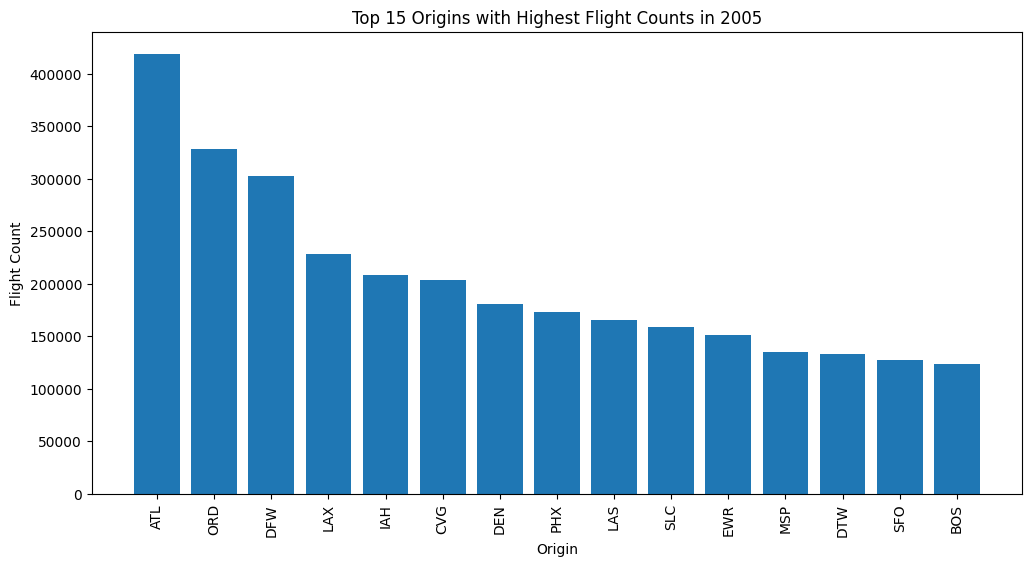

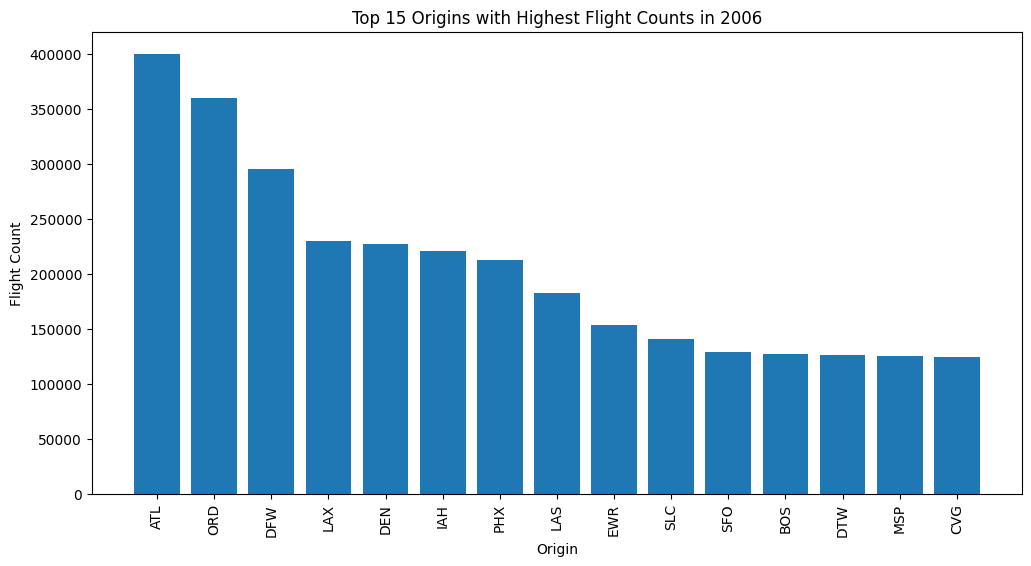

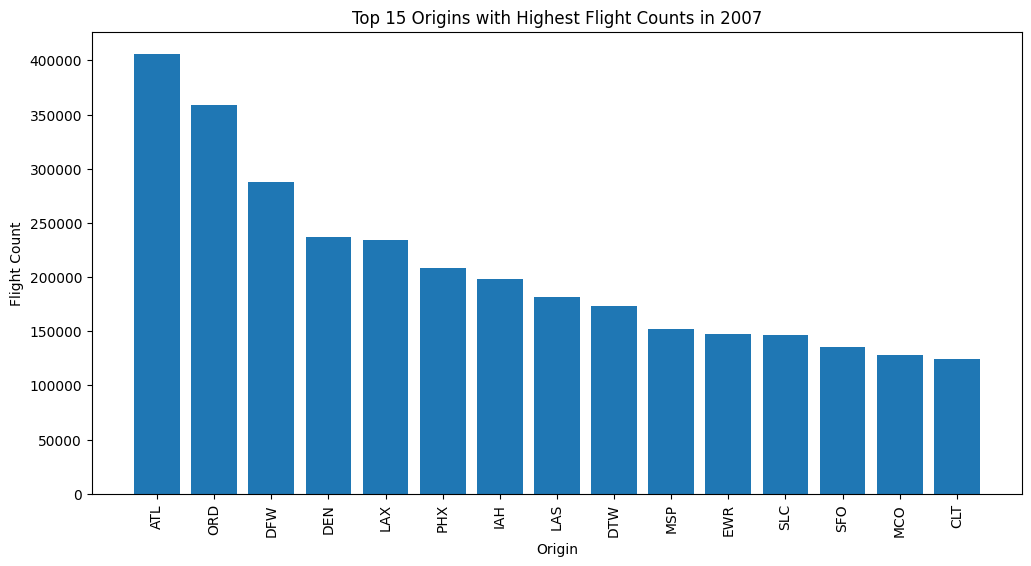

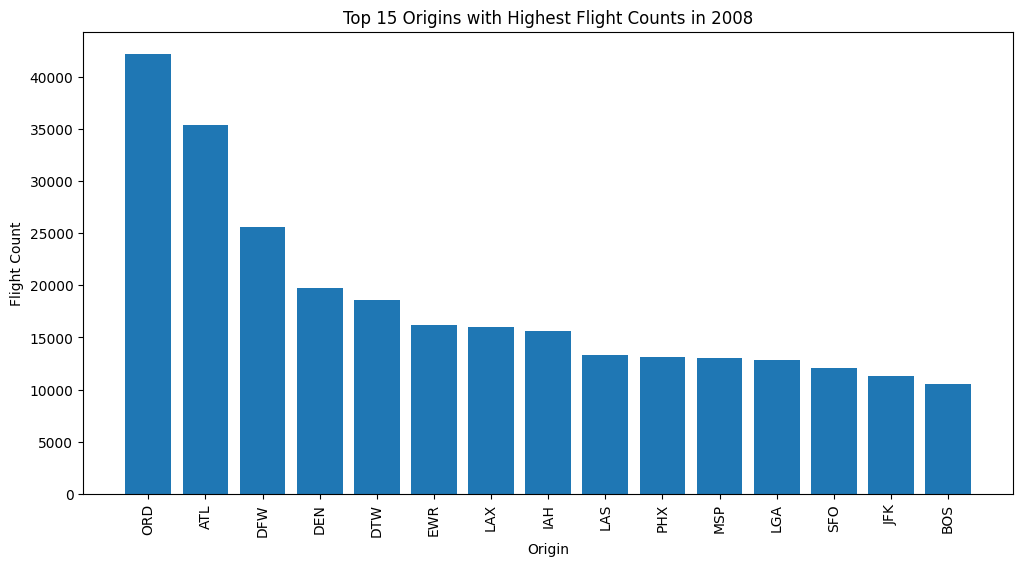

In [48]:
top_origins_pd = top_origins_yearly.toPandas()

# Step 8: Plot graph for each year
years = top_origins_pd["year"].unique()
for year in years:
    year_data = top_origins_pd[top_origins_pd["year"] == year]
    origins = year_data["origin"]
    flight_counts = year_data["count"]

    plt.figure(figsize=(12, 6))
    plt.bar(origins, flight_counts)
    plt.xlabel("Origin")
    plt.ylabel("Flight Count")
    plt.title(f"Top 15 Origins with Highest Flight Counts in {year}")
    plt.xticks(rotation=90)
    plt.show()

**Delays w.r.t years**

In [49]:
Delay_df = airline_df["year", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
Delay_df

DataFrame[year: bigint, WeatherDelay: bigint, NASDelay: bigint, SecurityDelay: bigint, LateAircraftDelay: bigint]

In [50]:
airline_df = airline_df.withColumn("WeatherDelay", airline_df["WeatherDelay"].cast("double"))
airline_df = airline_df.withColumn("NASDelay", airline_df["NASDelay"].cast("double"))
airline_df = airline_df.withColumn("SecurityDelay", airline_df["SecurityDelay"].cast("double"))
airline_df = airline_df.withColumn("LateAircraftDelay", airline_df["LateAircraftDelay"].cast("double"))
# Step 4: Check for missing or null values in the "WeatherDelay" column
airline_df = airline_df.filter(airline_df["WeatherDelay"].isNotNull())
airline_df = airline_df.filter(airline_df["NASDelay"].isNotNull())
airline_df = airline_df.filter(airline_df["SecurityDelay"].isNotNull())
airline_df = airline_df.filter(airline_df["LateAircraftDelay"].isNotNull())

delay_cols = ["WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
delay_data = airline_df.groupBy("year").sum(*delay_cols).orderBy("year")

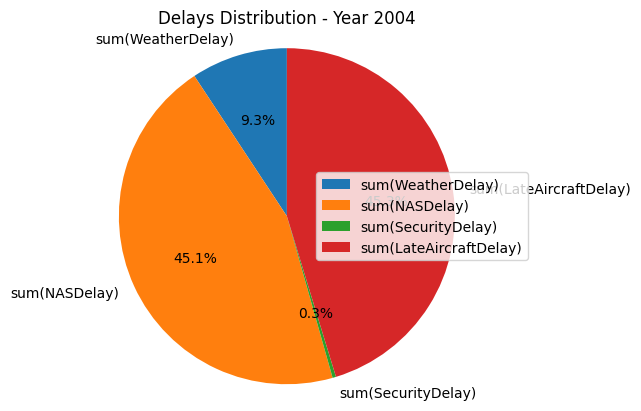

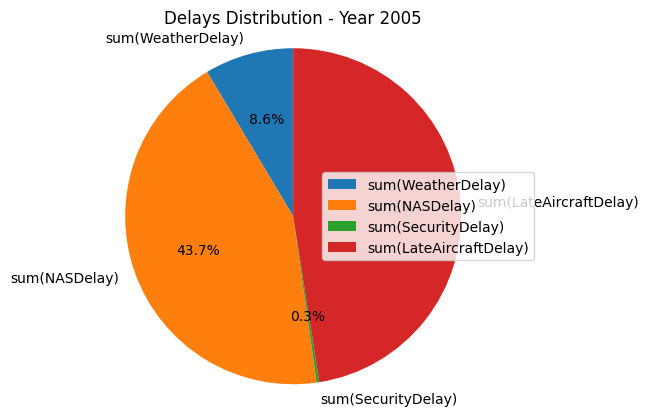

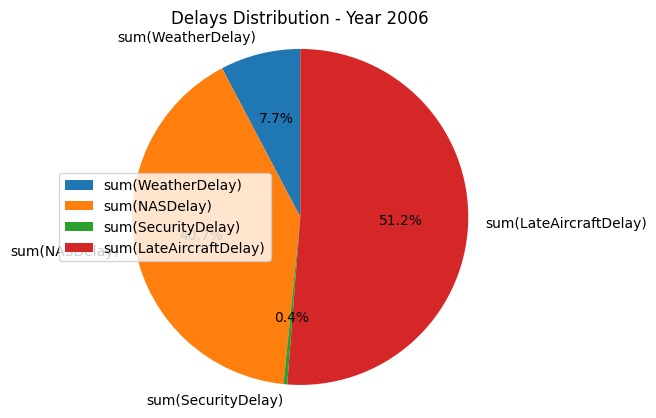

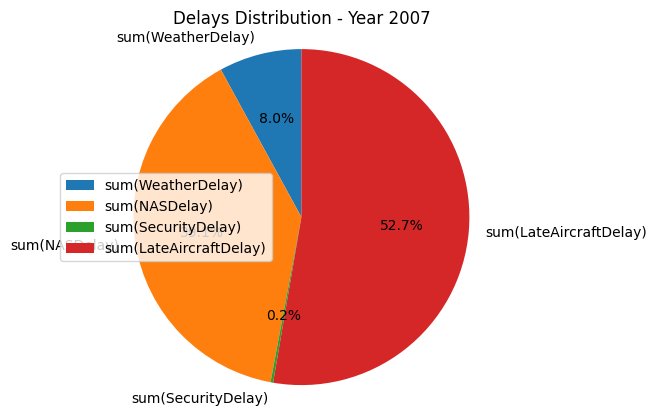

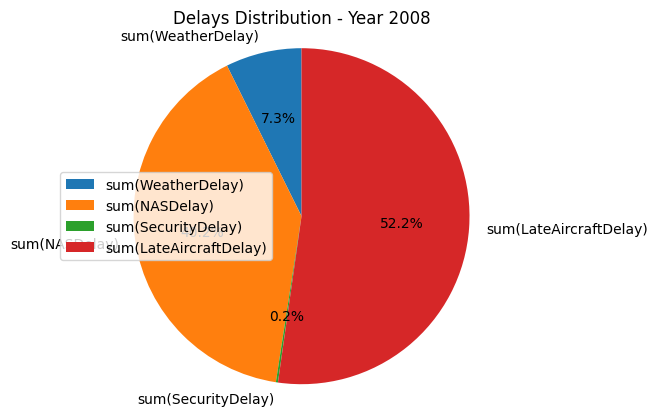

In [51]:
delay_cols=["sum(WeatherDelay)", "sum(NASDelay)", "sum(SecurityDelay)","sum(LateAircraftDelay)" ]
for row in delay_data.collect():
    year = row["year"]
    delays = [row[col] for col in delay_cols]
    plt.figure()
    plt.pie(delays, labels=delay_cols, autopct="%1.1f%%", startangle=90)
    plt.title(f"Delays Distribution - Year {year}")
    plt.axis("equal")
    plt.legend()
    plt.show()

In [34]:
groupedDelay = sqlC.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()

In [35]:
df_origin.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay
323,FMN,1,240.000000
321,OGD,5,172.400000
319,CYS,1,105.000000
318,PUB,2,104.000000
237,MKG,18,50.277778


In [ ]:
Origin_Airport="SJC"
df_ORG = sqlC.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

**MODEL**

In [36]:
# Feature selection
df_model=airline_df
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)
encoder1 = OneHotEncoder(dropLast=False, inputCol="originIndex", outputCol="originVec")
df_model = encoder1.fit(indexedOrigin).transform(indexedOrigin)

In [37]:
strIdx = StringIndexer(inputCol = "UniqueCarrier", outputCol = "CarrierIdx")
indexedOrigin = strIdx.fit(df_model).transform(df_model)
encoder1 = OneHotEncoder(dropLast=False, inputCol="CarrierIdx", outputCol="CarrierVec")
df_model = encoder1.fit(indexedOrigin).transform(indexedOrigin)



In [38]:

from pyspark.ml import linalg as ml_linalg
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
def as_mllib(v):
    if isinstance(v, ml_linalg.SparseVector):
        return MLLibVectors.sparse(v.size, v.indices, v.values)
    elif isinstance(v, ml_linalg.DenseVector):
        return MLLibVectors.dense(v.toArray())
    else:
        raise TypeError("Unsupported type: {0}".format(type(v)))

In [39]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','originVec','CarrierVec'],
    outputCol = "features")
output = assembler.transform(df_model)
airlineRDD=output.rdd.map(lambda row: LabeledPoint([0,1][row['DepDelayed']],as_mllib(row['features'])))

In [40]:
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])

In [41]:
# Build the model
model = LogisticRegressionWithLBFGS.train(trainRDD)

In [42]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))

In [43]:
labelsAndPreds

PythonRDD[647] at RDD at PythonRDD.scala:53

In [ ]:
# predictions = model.transform(test_data)

# # Select the predicted label and the true label from the predictions DataFrame
# prediction_and_label = predictions.select("prediction", "label")

# # Create an instance of MulticlassClassificationEvaluator to compute accuracy
# evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# # Compute accuracy by comparing the predicted label with the true label
# accuracy = evaluator.evaluate(prediction_and_label)

# # Print the accuracy
# print("Accuracy:", accuracy)

In [44]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda v: (v,1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [45]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print("Model Accuracy for JFK: %1.2f %%" % (Accuracy*100))

Model Accuracy for JFK: 80.63 %


In [ ]:
import pickle
# Specify the path where you want to save the pickled model
model_path = "/content/sample_data/pickled_model.pkl"

# Pickle the model
with open(model_path, 'wb') as f:
    pickle.dump(model, f)